In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from torch.utils import data
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.autograd import Variable
import torchvision.transforms as transforms
import time

from autoencoder import autoencoder, train, evaluate
from dataset import Dataset

# Model

In [2]:
save_model_path = './ae_models/ae/'

# EncoderCNN architecture
fc_hidden1 = 256
embed_dim = 32     # latent dim extracted by 2D CNN
dropout_p = 0.2       # dropout probability

# training parameters
start_epoch = 0
epochs = 20     # training epochs
batch_size = 8
learning_rate = 1e-3
log_interval = 1000   # interval for displaying training info

In [3]:
# Detect devices
use_cuda = torch.cuda.is_available()                   # check if GPU exists
device = torch.device("cuda" if use_cuda else "cpu")   # use CPU or GPU

# Data loading parameters
params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 4, 'pin_memory': True} if use_cuda else {}
transform = transforms.Compose([transforms.ToTensor(),
                                #transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # gray -> GRB 3 channel (lambda function)
                                #transforms.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0])
                               ])  # for grayscale images

# tiles dataset
tiles_dataset = Dataset(dir_path='../WSI/tiles/', transform=transform, dataset='tr')

# Data loader 
train_loader = torch.utils.data.DataLoader(dataset=tiles_dataset, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)
#valid_loader = torch.utils.data.DataLoader(dataset=tiles_dataset, batch_size=batch_size, shuffle=False)

# Create model
autoencoder = autoencoder(fc_hidden1=fc_hidden1, drop_p=dropout_p, embed_dim=embed_dim).to(device, non_blocking=True)
    
# Recover model                                
if start_epoch != 0:
    model_load_path = os.path.join(save_model_path, 'model_epoch{}.pth'.format(start_epoch))
    autoencoder.load_state_dict(torch.load(model_load_path))

print("Using", torch.cuda.device_count(), "GPU")
model_params = list(autoencoder.parameters())
optimizer = torch.optim.Adam(model_params, lr=learning_rate)
# Recover optimizer                                
if start_epoch != 0:
    optimizer_load_path = os.path.join(save_model_path, 'optimizer_epoch{}.pth'.format(start_epoch))
    optimizer.load_state_dict(torch.load(optimizer_load_path))
    

epoch_train_losses = []
epoch_test_losses = []

# start training
for epoch in range(start_epoch, epochs):

    # train, test model
    X_train, z_train, train_losses = train(log_interval, autoencoder, device, train_loader, optimizer, epoch, save_model_path)
    #X_test, y_test, z_test, mu_test, logvar_test, epoch_test_loss = validation(resnet_vae, device, optimizer, valid_loader)

    # save results
    epoch_train_losses.append(train_losses)
    #epoch_test_losses.append(epoch_test_loss)

    
    # save all train test results
    A = np.array(epoch_train_losses)
    #C = np.array(epoch_test_losses)
    
    np.save(os.path.join(save_model_path, 'autoencoder_training_loss.npy'), A)
    np.save(os.path.join(save_model_path, 'X_ae_train_epoch{}.npy'.format(epoch + 1)), X_train) #save last batch
    np.save(os.path.join(save_model_path, 'z_ae_train_epoch{}.npy'.format(epoch + 1)), z_train)

Using 1 GPU
Train Epoch: 1 [8000/1309486 (1%)]	Loss: 46248.082031
Train Epoch: 1 [16000/1309486 (1%)]	Loss: 37759.929688
Train Epoch: 1 [24000/1309486 (2%)]	Loss: 48941.843750
Train Epoch: 1 [32000/1309486 (2%)]	Loss: 38080.757812
Train Epoch: 1 [40000/1309486 (3%)]	Loss: 40175.367188
Train Epoch: 1 [48000/1309486 (4%)]	Loss: 40559.285156
Train Epoch: 1 [56000/1309486 (4%)]	Loss: 41244.195312
Train Epoch: 1 [64000/1309486 (5%)]	Loss: 37064.984375
Train Epoch: 1 [72000/1309486 (5%)]	Loss: 42079.996094
Train Epoch: 1 [80000/1309486 (6%)]	Loss: 42243.523438
Train Epoch: 1 [88000/1309486 (7%)]	Loss: 40269.347656
Train Epoch: 1 [96000/1309486 (7%)]	Loss: 41192.726562
Train Epoch: 1 [104000/1309486 (8%)]	Loss: 39926.460938
Train Epoch: 1 [112000/1309486 (9%)]	Loss: 38056.378906
Train Epoch: 1 [120000/1309486 (9%)]	Loss: 38915.656250
Train Epoch: 1 [128000/1309486 (10%)]	Loss: 36561.000000
Train Epoch: 1 [136000/1309486 (10%)]	Loss: 41966.855469
Train Epoch: 1 [144000/1309486 (11%)]	Loss: 372

Show training loss

In [4]:
ae_loss_train = np.load(save_model_path+'/autoencoder_training_loss.npy')
print(ae_loss_train.shape)
print(ae_loss_train)

(20, 163685)
[[71545.328125   70975.140625   70417.421875   ... 39303.56640625
  35512.20703125 38439.3984375 ]
 [39098.61328125 35166.28515625 39041.21484375 ... 38016.46875
  40186.1953125  35283.3046875 ]
 [36541.3828125  37781.11328125 36086.01171875 ... 40265.44921875
  38248.640625   39695.0703125 ]
 ...
 [39321.1328125  41430.8984375  39124.3671875  ... 39837.90625
  37137.5234375  39156.5390625 ]
 [38816.3359375  36866.0703125  43822.3203125  ... 38284.0234375
  41085.078125   40760.7421875 ]
 [39500.51171875 38099.1953125  40881.03125    ... 39864.62890625
  35835.67578125 37615.39453125]]


[38885.89458641 38641.3736713  38621.90975302 38611.69315601
 38604.99246506 38599.78575334 38595.23700282 38591.69774939
 38588.72012555 38586.48332883 38584.60108565 38582.95643312
 38581.53827514 38580.24141399 38578.98082685 38578.06584902
 38577.18614987 38576.43666789 38575.57259353 38574.94935338]


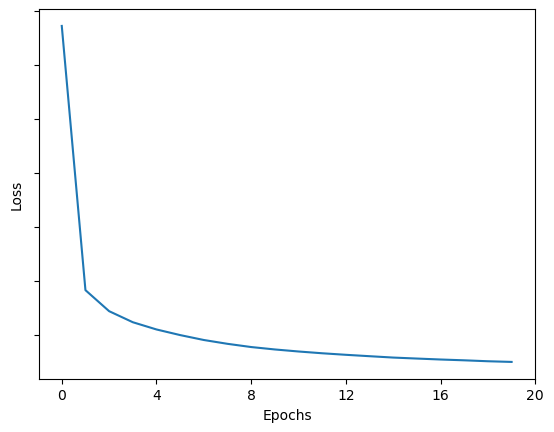

In [14]:
avg_epoch_loss = np.average(ae_loss_train, axis=1)
print(avg_epoch_loss)

plt.plot(avg_epoch_loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yticks(ticks=[38900, 38850, 38800, 38750, 38700, 38650, 38600],labels=[])
plt.xticks(ticks=[4*i for i in range(6)])
plt.show()

Predict on tr set

In [4]:
recover_epoch = 20

# Detect devices
use_cuda = torch.cuda.is_available()                   # check if GPU exists
device = torch.device("cuda" if use_cuda else "cpu")   # use CPU or GPU

# Data loading parameters
params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 4, 'pin_memory': True} if use_cuda else {}
transform = transforms.Compose([transforms.ToTensor(),
                               ])

# tiles dataset
tiles_dataset = Dataset(dir_path='../WSI/tiles/', transform=transform, dataset='tr')

# Data loader 
valid_loader = torch.utils.data.DataLoader(dataset=tiles_dataset, batch_size=batch_size, shuffle=False)

# Create model
autoencoder = autoencoder(fc_hidden1=fc_hidden1, drop_p=dropout_p, embed_dim=embed_dim).to(device)
    
# Recover model                                
model_load_path = os.path.join(save_model_path, 'model_epoch{}.pth'.format(recover_epoch))
autoencoder.load_state_dict(torch.load(model_load_path))

print("Using", torch.cuda.device_count(), "GPU")
model_params = list(autoencoder.parameters())
optimizer = torch.optim.Adam(model_params, lr=learning_rate)

# Recover optimizer                                
optimizer_load_path = os.path.join(save_model_path, 'optimizer_epoch{}.pth'.format(recover_epoch))
optimizer.load_state_dict(torch.load(optimizer_load_path))
    

# Evaluate

X_test, z_test, X_reconst_test, epoch_test_loss = evaluate(log_interval, autoencoder, device, optimizer, valid_loader)

        
np.save(os.path.join(save_model_path, 'AE_test_loss.npy'), epoch_test_loss)
np.save(os.path.join(save_model_path, 'X_ae_test_epoch{}.npy'.format(recover_epoch)), X_test)
np.save(os.path.join(save_model_path, 'z_ae_test_epoch{}.npy'.format(recover_epoch)), z_test)
np.save(os.path.join(save_model_path, 'X_reconst_test_epoch{}.npy'.format(recover_epoch)), X_reconst_test)


Using 1 GPU
Eval: [8000/1309486 (1%)]	Loss: 33060.929688
Eval: [16000/1309486 (1%)]	Loss: 35236.378906
Eval: [24000/1309486 (2%)]	Loss: 35466.214844
Eval: [32000/1309486 (2%)]	Loss: 34721.296875
Eval: [40000/1309486 (3%)]	Loss: 35039.175781
Eval: [48000/1309486 (4%)]	Loss: 32412.117188
Eval: [56000/1309486 (4%)]	Loss: 39307.292969
Eval: [64000/1309486 (5%)]	Loss: 38355.195312
Eval: [72000/1309486 (5%)]	Loss: 35446.828125
Eval: [80000/1309486 (6%)]	Loss: 50918.410156
Eval: [88000/1309486 (7%)]	Loss: 55088.156250
Eval: [96000/1309486 (7%)]	Loss: 37801.089844
Eval: [104000/1309486 (8%)]	Loss: 46589.015625
Eval: [112000/1309486 (9%)]	Loss: 52493.839844
Eval: [120000/1309486 (9%)]	Loss: 31926.824219
Eval: [128000/1309486 (10%)]	Loss: 44575.347656
Eval: [136000/1309486 (10%)]	Loss: 39596.308594
Eval: [144000/1309486 (11%)]	Loss: 41060.851562
Eval: [152000/1309486 (12%)]	Loss: 34182.140625
Eval: [160000/1309486 (12%)]	Loss: 34724.046875
Eval: [168000/1309486 (13%)]	Loss: 40271.500000
Eval: [1

# Internal Test set

In [3]:
recover_epoch = 20

# Detect devices
use_cuda = torch.cuda.is_available()                   # check if GPU exists
device = torch.device("cuda" if use_cuda else "cpu")   # use CPU or GPU

# Data loading parameters
params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 4, 'pin_memory': True} if use_cuda else {}
transform = transforms.Compose([transforms.ToTensor(),
                               ])

# tiles dataset
tiles_dataset = Dataset(dir_path='../WSI/tiles/', transform=transform, dataset='ts')

# Data loader 
valid_loader = torch.utils.data.DataLoader(dataset=tiles_dataset, batch_size=batch_size, shuffle=False)

# Create model
autoencoder = autoencoder(fc_hidden1=fc_hidden1, drop_p=dropout_p, embed_dim=embed_dim).to(device)
    
# Recover model                                
model_load_path = os.path.join(save_model_path, 'model_epoch{}.pth'.format(recover_epoch))
autoencoder.load_state_dict(torch.load(model_load_path))

print("Using", torch.cuda.device_count(), "GPU")
model_params = list(autoencoder.parameters())
optimizer = torch.optim.Adam(model_params, lr=learning_rate)

# Recover optimizer                                
optimizer_load_path = os.path.join(save_model_path, 'optimizer_epoch{}.pth'.format(recover_epoch))
optimizer.load_state_dict(torch.load(optimizer_load_path))
    

# Evaluate

X_test, z_test, X_reconst_test, epoch_test_loss = evaluate(log_interval, autoencoder, device, optimizer, valid_loader)

    
        
np.save(os.path.join(save_model_path, 'AE_internal_test_loss.npy'), epoch_test_loss)
np.save(os.path.join(save_model_path, 'X_ae_internal_test_epoch{}.npy'.format(recover_epoch)), X_test)
np.save(os.path.join(save_model_path, 'z_ae_internal_test_epoch{}.npy'.format(recover_epoch)), z_test)
np.save(os.path.join(save_model_path, 'X_reconst_internal_test_epoch{}.npy'.format(recover_epoch)), X_reconst_test)

Using 1 GPU
Eval: [8000/206606 (4%)]	Loss: 35052.765625
Eval: [16000/206606 (8%)]	Loss: 43821.136719
Eval: [24000/206606 (12%)]	Loss: 37380.542969
Eval: [32000/206606 (15%)]	Loss: 36236.531250
Eval: [40000/206606 (19%)]	Loss: 38896.359375
Eval: [48000/206606 (23%)]	Loss: 35486.359375
Eval: [56000/206606 (27%)]	Loss: 34534.472656
Eval: [64000/206606 (31%)]	Loss: 35624.203125
Eval: [72000/206606 (35%)]	Loss: 40547.000000
Eval: [80000/206606 (39%)]	Loss: 34803.140625
Eval: [88000/206606 (43%)]	Loss: 33519.859375
Eval: [96000/206606 (46%)]	Loss: 37413.722656
Eval: [104000/206606 (50%)]	Loss: 34898.296875
Eval: [112000/206606 (54%)]	Loss: 33045.585938
Eval: [120000/206606 (58%)]	Loss: 35537.781250
Eval: [128000/206606 (62%)]	Loss: 38671.828125
Eval: [136000/206606 (66%)]	Loss: 31723.685547
Eval: [144000/206606 (70%)]	Loss: 30760.294922
Eval: [152000/206606 (74%)]	Loss: 30764.140625
Eval: [160000/206606 (77%)]	Loss: 37341.531250
Eval: [168000/206606 (81%)]	Loss: 43183.511719
Eval: [176000/20

# External Test Set

In [3]:
recover_epoch = 20

# Detect devices
use_cuda = torch.cuda.is_available()                   # check if GPU exists
device = torch.device("cuda" if use_cuda else "cpu")   # use CPU or GPU

# Data loading parameters
params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 4, 'pin_memory': True} if use_cuda else {}
transform = transforms.Compose([transforms.ToTensor(),
                                # Normalize to have tr dataset mean and std (params calculated in norm_params.ipynb
                                #transforms.Normalize(mean=[-0.2792, -0.2173, -0.0899], std=[1.2762, 1.2154, 1.0878], inplace=True)
                               ])

# tiles dataset
tiles_dataset = Dataset(dir_path='../WSI/tiles/', transform=transform, dataset='ext')

# Data loader 
valid_loader = torch.utils.data.DataLoader(dataset=tiles_dataset, batch_size=batch_size, shuffle=False)

# Create model
autoencoder = autoencoder(fc_hidden1=fc_hidden1, drop_p=dropout_p, embed_dim=embed_dim).to(device)
    
# Recover model                                
model_load_path = os.path.join(save_model_path, 'model_epoch{}.pth'.format(recover_epoch))
autoencoder.load_state_dict(torch.load(model_load_path))

print("Using", torch.cuda.device_count(), "GPU")
model_params = list(autoencoder.parameters())
optimizer = torch.optim.Adam(model_params, lr=learning_rate)

# Recover optimizer                                
optimizer_load_path = os.path.join(save_model_path, 'optimizer_epoch{}.pth'.format(recover_epoch))
optimizer.load_state_dict(torch.load(optimizer_load_path))
    

# Evaluate
X_test, z_test, X_reconst_test, epoch_test_loss = evaluate(log_interval, autoencoder, device, optimizer, valid_loader)

        
np.save(os.path.join(save_model_path, 'AE_ext_test_loss.npy'), epoch_test_loss)
np.save(os.path.join(save_model_path, 'X_ae_ext_test_epoch{}.npy'.format(recover_epoch)), X_test)
np.save(os.path.join(save_model_path, 'z_ae_ext_test_epoch{}.npy'.format(recover_epoch)), z_test)
#np.save(os.path.join(save_model_path, 'X_reconst_ext_test_epoch{}.npy'.format(recover_epoch)), X_reconst_test)

Using 1 GPU
Eval: [8000/545326 (1%)]	Loss: 37496.898438
Eval: [16000/545326 (3%)]	Loss: 38869.218750
Eval: [24000/545326 (4%)]	Loss: 36126.898438
Eval: [32000/545326 (6%)]	Loss: 35333.132812
Eval: [40000/545326 (7%)]	Loss: 54255.375000
Eval: [48000/545326 (9%)]	Loss: 67768.734375
Eval: [56000/545326 (10%)]	Loss: 39079.984375
Eval: [64000/545326 (12%)]	Loss: 37335.082031
Eval: [72000/545326 (13%)]	Loss: 39311.414062
Eval: [80000/545326 (15%)]	Loss: 44714.281250
Eval: [88000/545326 (16%)]	Loss: 42738.597656
Eval: [96000/545326 (18%)]	Loss: 36847.679688
Eval: [104000/545326 (19%)]	Loss: 41668.242188
Eval: [112000/545326 (21%)]	Loss: 38707.687500
Eval: [120000/545326 (22%)]	Loss: 37313.058594
Eval: [128000/545326 (23%)]	Loss: 51559.769531
Eval: [136000/545326 (25%)]	Loss: 42461.039062
Eval: [144000/545326 (26%)]	Loss: 42559.394531
Eval: [152000/545326 (28%)]	Loss: 43168.808594
Eval: [160000/545326 (29%)]	Loss: 42373.980469
Eval: [168000/545326 (31%)]	Loss: 39734.722656
Eval: [176000/545326